*1. Introduction*

Alzheimer’s disease is a progressive neurological disorder that affects millions worldwide. Early detection and classification of its different stages can help in better management and treatment planning. This project uses a Convolutional Neural Network (CNN) to classify images into four categories:

Mild Dementia

Moderate Dementia

Non-Demented

Very Mild Dementia

We use TensorFlow and Keras to build and train a deep learning model for this classification task.

*2. Dataset Overview*

The dataset is structured as a folder containing four subfolders, each representing a different class. The images within these subfolders serve as input for the CNN model. The dataset is loaded and preprocessed using TensorFlow’s image_dataset_from_directory function.

Dataset Structure

📁 Alzheimer_Dataset/

├── 📂 Mild Dementia/

├── 📂 Moderate Dementia/

├── 📂 Non-Demented/

└── 📂 Very Mild Dementia/

Each folder contains medical images related to that category, which the CNN will learn to classify.


*3. Data Preprocessing*

Before training the CNN, the dataset needs to be preprocessed to ensure compatibility with the model. This involves:

Loading Images: Reading images from directories.
Resizing Images: Ensuring all images are of a fixed size (224x224 pixels).
Batching: Dividing images into small batches for efficient processing (batch size = 32).
Normalization: Scaling pixel values from 0-255 to 0-1 to improve model performance.

Found 86437 files belonging to 4 classes.
Using 69150 files for training.
Found 86437 files belonging to 4 classes.
Using 17287 files for validation.
Class Names: ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']


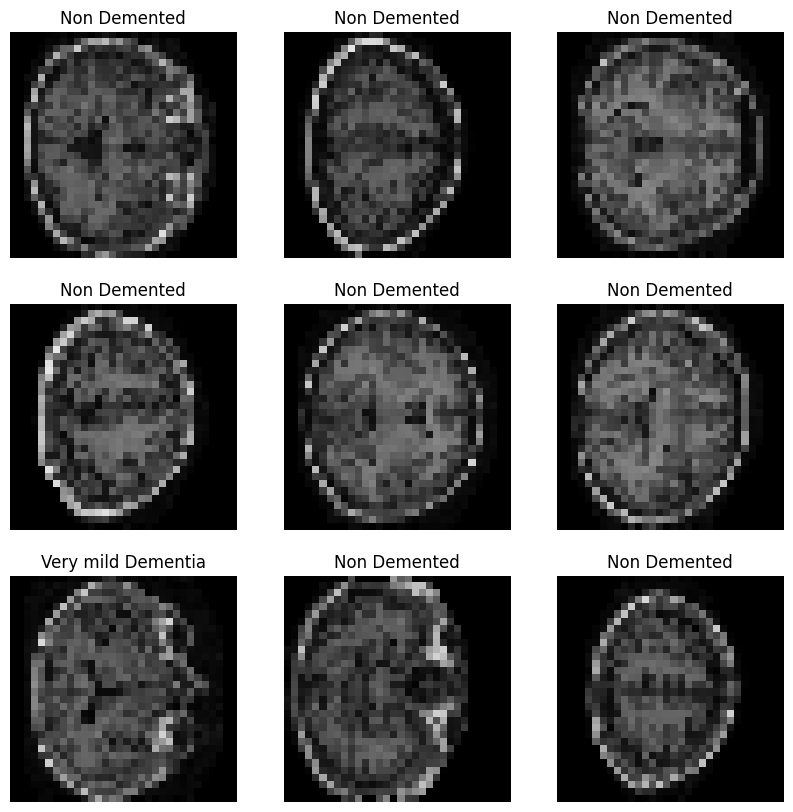

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Define dataset path
dataset_path = "/kaggle/input/alzheimers-detection/Data"  

# Load dataset with 80-20 train-validation split
train_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(32, 32),
    batch_size=32
)

val_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(32, 32),
    batch_size=32
)

# Get class names
class_names = train_ds.class_names
print(f"Class Names: {class_names}")

# Normalize images
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Prefetch data for performance improvement
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# Preview sample images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")
plt.show()

*4. Building the CNN Model*

A Convolutional Neural Network (CNN) is used for feature extraction and classification. The CNN consists of:

Convolutional Layers: Extract spatial features from images.

Max Pooling Layers: Reduce dimensions while keeping essential information.

Dropout Layers: Prevent overfitting by randomly turning off neurons.

Fully Connected (Dense) Layers: Classify images into the four categories.

In [2]:
model = Sequential([
    tf.keras.layers.Input(shape=(32, 32, 3)), 

    # Convolutional Layer 1
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    # Convolutional Layer 2
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    # Convolutional Layer 3
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    # Flattening
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Model Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16, 16, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 8, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4, 4, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,204 (121.89 KB)

 Trainable params: 31,044 (121.27 KB)

 Non-trainable params: 160 (640.00 B)

*5. Training the Model*

The model is trained for 10 epochs to learn patterns in the dataset. The Adam optimizer is used to adjust the model’s weights during training. The sparse categorical cross-entropy loss function is used since this is a multi-class classification problem.

In [3]:
# Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 102s 46ms/step - accuracy: 0.7811 - loss: 0.5692 - val_accuracy: 0.8672 - val_loss: 0.3269
Epoch 2/10
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 78s 36ms/step - accuracy: 0.8925 - loss: 0.2612 - val_accuracy: 0.9238 - val_loss: 0.1747
Epoch 3/10
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 79s 36ms/step - accuracy: 0.9408 - loss: 0.1572 - val_accuracy: 0.9770 - val_loss: 0.0643
Epoch 4/10
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 79s 36ms/step - accuracy: 0.9594 - loss: 0.1075 - val_accuracy: 0.9531 - val_loss: 0.1587
Epoch 5/10
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 78s 36ms/step - accuracy: 0.9669 - loss: 0.0904 - val_accuracy: 0.9689 - val_loss: 0.0779
Epoch 6/10
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 78s 36ms/step - accuracy: 0.9751 - loss: 0.0684 - val_accuracy: 0.9883 - val_loss: 0.0363
Epoch 7/10
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 82s 36ms/step - accuracy: 0.9802 - loss: 0.0586 - val_accuracy: 0.9895 - val_loss: 0.0284
Epoch 8/10
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 83s 37ms/step - accuracy: 0.9826 

*6. Evaluating Model Performance*

After training, the model’s accuracy and loss are analyzed using graphs to check performance.

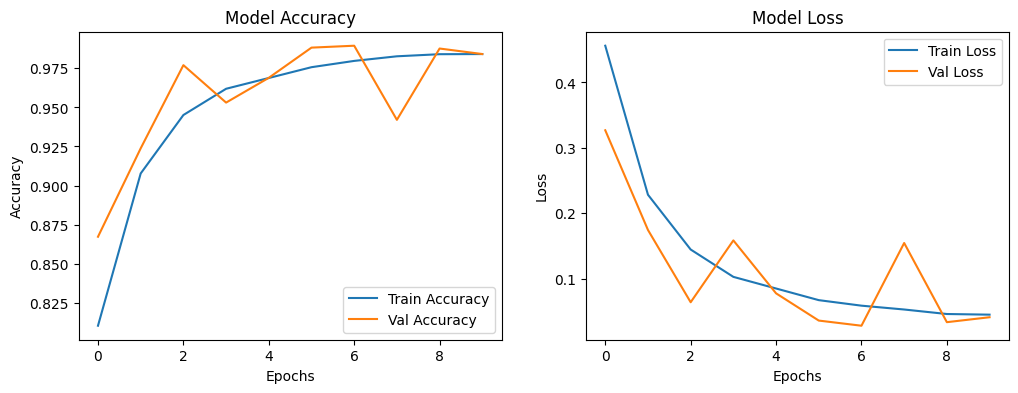

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━

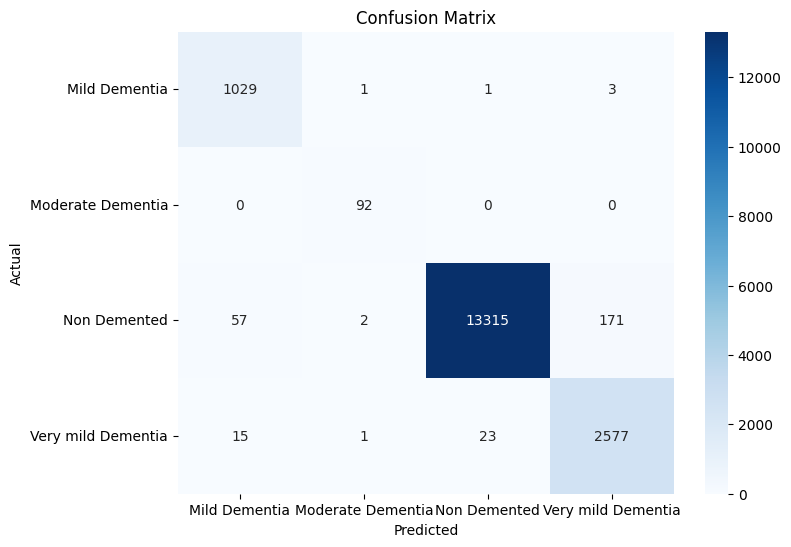

Classification Report:
                    precision    recall  f1-score   support

     Mild Dementia       0.93      1.00      0.96      1034
 Moderate Dementia       0.96      1.00      0.98        92
      Non Demented       1.00      0.98      0.99     13545
Very mild Dementia       0.94      0.99      0.96      2616

          accuracy                           0.98     17287
         macro avg       0.96      0.99      0.97     17287
      weighted avg       0.98      0.98      0.98     17287



In [4]:
# Plot Accuracy & Loss Curves
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

*7. Saving and Loading the Model*

To use the trained model for future predictions, it is saved in the .h5 format.

In [5]:
# Save model
model.save("cnn_image_classifier.h5")
print("Model saved successfully!")

# Load model (optional)
# loaded_model = tf.keras.models.load_model("cnn_image_classifier.h5")

Model saved successfully!


*8. Making Predictions on New Images*

Once the model is trained, we can use it to classify new images. The image is first resized to 224x224 pixels, converted into an array, and then passed into the model.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


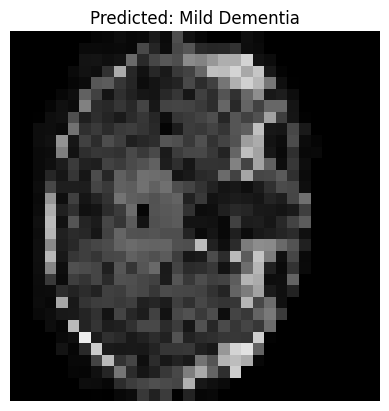

In [6]:
def predict_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(32, 32)) 
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize

    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]
    
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis("off")
    plt.show()

# Test on a new image
test_image_path = "/kaggle/input/alzheimers-detection/Data/Mild Dementia/OAS1_0028_MR1_mpr-1_105.jpg"
predict_image(test_image_path)
